# Proj 1

## 1. Working with data

We are planning to use the MNIST (https://web.archive.org/web/20200430193701/http://yann.lecun.com/exdb/mnist/) dataset. The MNIST dataset consists of 70,000 (60,000 in the training set and 10,000 in the testing set) 28x28 grayscale images of labeled, handwritten digits. The dataset was created by Yann LeCun, who mixed NIST's (National Institute of Standards and Technology) datasets SD-1 (Special Database 1) and SD-3.

Note that Wikipedia (https://en.wikipedia.org/wiki/MNIST_database) (erroneously?) believes that MNIST is a mix of SD-7 and SD-3. However, Yann LeCun's original website post says that MNIST uses SD-1, not SD-7.

NIST collected SD-1 from 500 high school students in Bethesda, Maryland, and SD-3 from Census Bureau employees. Yann LeCun centered and anti-aliased the images.

This data is interesting to us because it contains small (28x28, grayscale) images that we plan to train a toy diffusion model on. We want to learn about diffusion models, so using a dataset like MNIST that is easy to work with (small, clean, preprocessed) will allow us to focus more on the diffusion modelling algorithm and less on data cleaning, etc.

This dataset was collected from a very non-representative demographic (wrt all Americans, NIST's target population): high school students in Maryland and US census workers. However, seeing as our project's goal is less focused on the actual problem of recognizing handwritten digits and more so to study diffusion models, we do not consider this potential bias to be problematic.

If we can get diffusion to work well on MNIST we will explore training diffusion models on more challenging datasets.

(60000, 28, 28) (60000,)


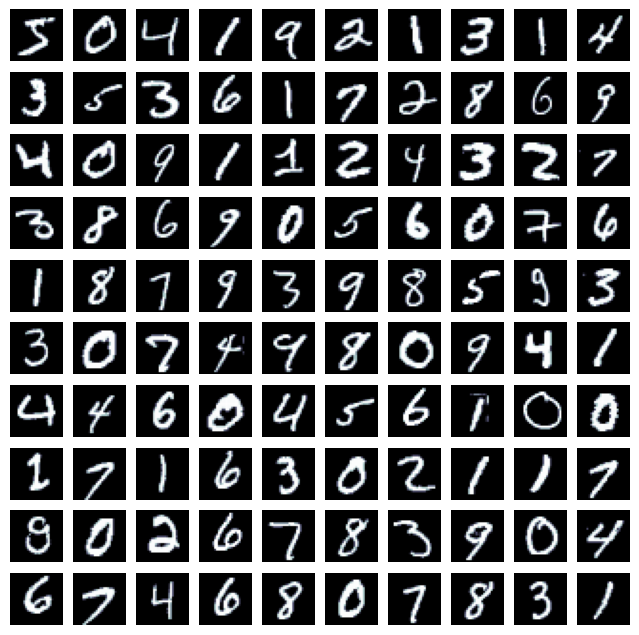

In [1]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

ds = MNIST(root="data", train=True, download=True)
images, labels = ds.data.numpy(), ds.targets.numpy()
print(images.shape, labels.shape)

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i, j].imshow(images[i * 10 + j], cmap="bone")
        axs[i,j].set_axis_off()
plt.show()

This is just a plot showing 100 MNIST digits.

Some interesting observations:
* digits differ in how bold they are -> different writing implements / scales?
* some cropping artifacts: numbers cut off at the bottom, boxy shape around 1 -> imperfections when centering and cropping
* very strange looking digits: some look like the letter "g"
* some digits look very similar (vertical run of 3 6s near the bottom left) -> same writer?
* diverse digit patterns (1s with and without base, 7 w/ and w/out bar, 4..)

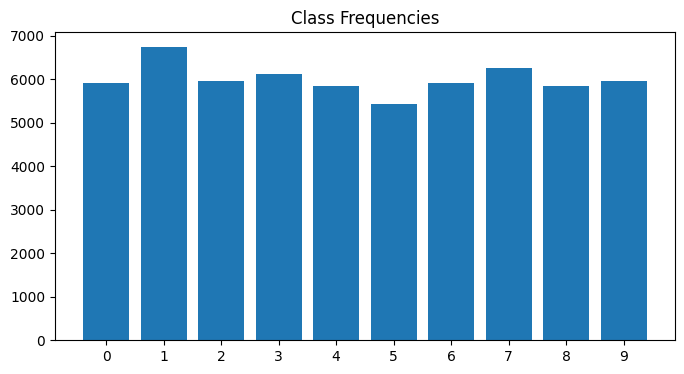

In [2]:
digits = np.arange(10)
class_freq = (labels == digits[:, None]).sum(axis=1)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(digits, class_freq)
ax.set_xticks(digits)
ax.set_title("Class Frequencies")
plt.show()

This plot shows the frequency of each digit in the training set. We can see that every digit has ~6,000 samples. This plot actually taught us something new because we initially thought that there was exactly 6,000 samples of each digit. However, we can see that digit frequencies differ slightly, with the most 1s and the least 5s.

(10000, 784)


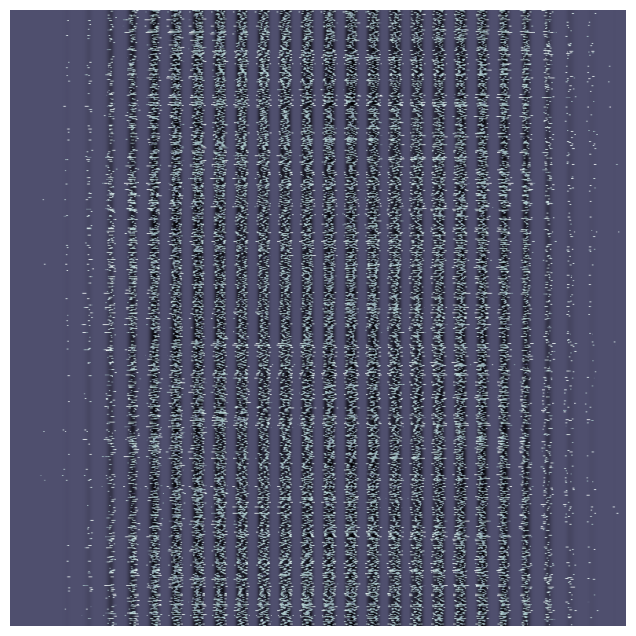

(10000, 784) (784,) (784, 784)


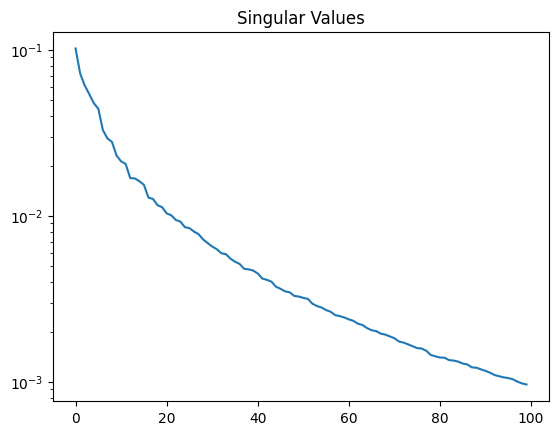

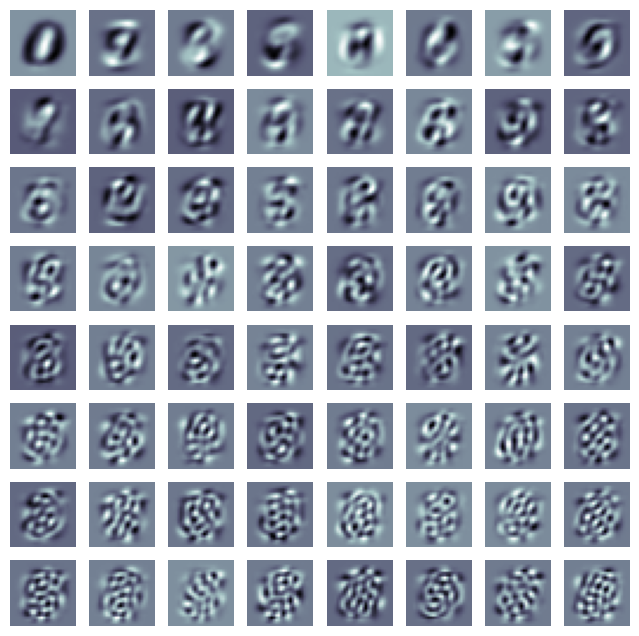

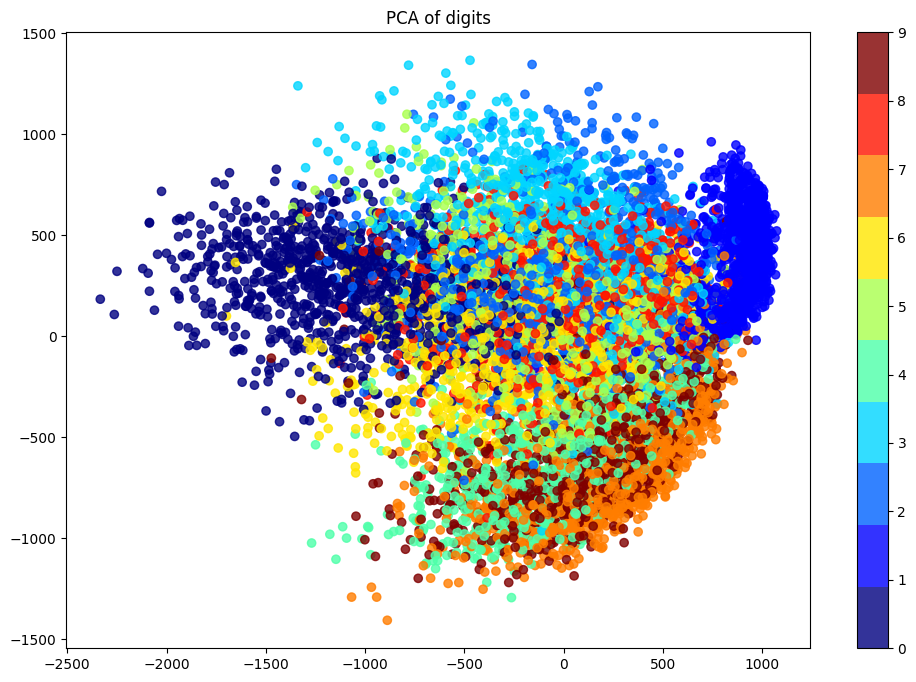

In [3]:
N_POINTS = 10000
M = images[:N_POINTS].reshape(-1, 784).astype(np.float32)
M = M - M.mean(axis=0, keepdims=True)
print(M.shape)
plt.figure(figsize=(8, 8))
plt.imshow(M[:784], cmap="bone")
plt.axis("off")
plt.show()

U, S, Vt = np.linalg.svd(M, full_matrices=False)
print(U.shape, S.shape, Vt.shape)

S2 = S ** 2
plt.plot(S2[:100] / S2.sum())
plt.yscale("log")
plt.title("Singular Values")
plt.show()

eigendigits = Vt.reshape(-1, 28, 28)
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i, j].imshow(eigendigits[i * 8 + j], cmap="bone")
        axs[i,j].set_axis_off()
plt.show()

images_2d = U[:, :2] * S[:2]
plt.figure(figsize=(12, 8))
sc = plt.scatter(images_2d[:, 0], images_2d[:, 1], c=labels[:N_POINTS], alpha=0.8, cmap=plt.get_cmap("jet", 10))
plt.colorbar(sc)
plt.title("PCA of digits")
plt.show();

Here we compute the PCA (SVD lol) of the MNIST dataset matrix (with each image flattened into a 784-dim vector). Plotting the singular value spectrum and eigendigits, we can see how much each eigendigit contributes to the digit dataset, as well as what the eigendigits look like. From the singular value spectrum, we see (expectedly) that the contribution from eigendigits falls off very quickly. Looking at the eigendigits, we can see some very interesting patterns. The eigendigits with the largest singular values look like sums and differences of digits, and every eigendigit has its patterns concentrated mostly in the center, which makes sense since every digit is centered. After a couple of rows, the eigendigits just start looking like centered texture patterns and not really like digits anymore.

Looking at the PCA plot, we can see that even though PCA is a linear dimensionality reduction algorithm, it still learns interesting relationships between the digit classes. PCA separates 1s and 0s nicely from the rest of the digits, which hints at 1s and 0s being very distinct from the other digits. PCA puts 9s, 4s, and 7s almost right on top of each other away from other digits, which hints at these digits looking very similar to one another.

# 2. Thinking about models

1. observed variable is only pixel intensities.
there is a relationship b/c all of the pixels together create a handwritten digit, but the relationship is not easy to write down (very high dimensional and nonlinear). furthermore, since we know that each writer contributed multiple digits to the dataset, there is some relationship between the digits of the same person (should look more similar). there is also some relationship between the location of the pixel and its intensity. for example, pixels near the edge will likely not have high intensities, but again, this relationship is not so simple to write down. 
independencies: unsure
conditional independencies: pixels in image ~conditionally independent given label. without conditioning on the label pixel intensities are very correlated between digits of the same class. conditioning on the label (and maybe a latent writer), the pixels from one digit to another could be conditionally independent. pixel intensities conditioned on location in image.
correlated: pixel intensities with each other, location, latent writer, latent label

2. hidden vars: latent label, latent writer, latent writing type (boldness, stroke pattern)
<ol type="a">
  <li>Writer identity – explains consistent handwriting characteristics across multiple digits written by the same person (slants, boldness, thickness, stroke shape, spacing).</li>
  <li>Writing style – captures variation in boldness, pen pressure, and curvature.</li>
  <li>Slant / rotation – represents the orientation or tilt of a digit (such as a number leaning left or right).</li>
  <li>Center offset – describes how centered or shifted the digit appears within the 28×28 frame.</li>
  <li>Digit size – captures how small or large a digit is written.</li>
  <li>Background noise – random artifacts or noise in pixel intensities.</li>
</ol>



3. problems: modelling probability distribution of all pixel intensities given label, modelling latent factors like writer / writing type
<ol type="a">
  <li>The data is very high dimensional. Each image consists of 784 observed random variables (one per pixel). Modeling the joint probability distribution over all pixels is challenging.</li>
  <li>The relationships between observed variables (pixel intensities) are complex. It is not clear how to write down or parameterize these dependencies.</li>
  <li>Variability across samples arises from different handwriting styles, such as differences in stroke boldness, slant, rotation, and size, that are not explained by the digit label alone.</li>
  <li>It is unclear which latent factors are most important for explaining the variation in the data. Factors such as writing style, rotation, and size may each explain part of the variance, but their relative importance is unknown.</li>
  <li>The MNIST dataset was collected from a small, narrow population. Models trained on MNIST may overfit this limited sample and fail to generalize to broader handwriting styles. Since our goal is to generate plausible new digits rather than memorize existing ones, overfitting and limited diversity are key concerns.</li>
</ol>